In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

## Dataset
Predict the time series shifted 1 toward future

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
Month              168 non-null object
Milk Production    168 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


None

,Month,Milk Production
0,1962-01-01 01:00:00,589.0
1,1962-02-01 01:00:00,561.0
2,1962-03-01 01:00:00,640.0
3,1962-04-01 01:00:00,656.0
4,1962-05-01 01:00:00,727.0


,Milk Production
count,168.00
mean,754.71
std,102.20
min,553.00
25%,677.75
50%,761.00
75%,824.50
max,969.00


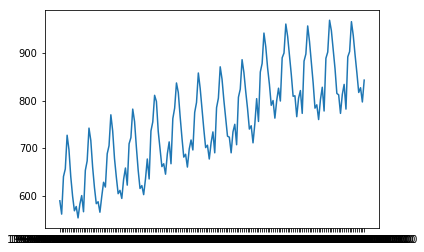

In [2]:
data = pd.read_csv('monthly-milk-production.csv',)

display(data.info())
display(data.head())
display(data.describe().round(2))
plt.plot(
    data['Month'],
    data['Milk Production'])

## Train/Test Split
Split continuously

In [3]:
timeseries = data['Milk Production'].values

train_ts = timeseries[:156]
test_ts = timeseries[156:]

print(train_ts.shape)
print(test_ts.shape)

(156,)
(12,)


## Feature Engineering
Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!

In [4]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

train_ts_sc = mms.fit_transform(train_ts.reshape(-1,1))
test_ts_sc = mms.transform(test_ts.reshape(-1,1))

print(train_ts_sc.shape)
print('')
print(test_ts_sc.shape)

(156, 1)

(12, 1)


## Next batch timeseries

In [5]:
def next_batch_ts(ts_dataset, batch_size, steps):
    # Grab a random starting point for each batch
    rand_start = np.random.randint(
        0,
        len(ts_dataset)-steps) 

    # Create a batch for time series
    ts_batch = np.array(ts_dataset[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    
    # Return 2 batch ts
    #   X_batch = ts
    #   y_batch = ts shifted 1 toward future
    return ts_batch[:, :-1].reshape(-1, steps, 1), \
        ts_batch[:, 1:].reshape(-1, steps, 1)

In [6]:
X_batch, y_batch = next_batch_ts(
    train_ts_sc,
    batch_size=1,
    steps=12)

display(X_batch.shape)
display(y_batch.shape)

(1, 12, 1)

(1, 12, 1)

## Model

In [7]:
# Placeholders
X_ph = tf.placeholder(tf.float32, [None, 12, 1])
y_ph = tf.placeholder(tf.float32, [None, 12, 1])

# Graph = GRU cell
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicLSTMCell(
        num_units=100,
        activation=tf.nn.relu),
    output_size=1)

y_pred, a_pred = tf.nn.dynamic_rnn(
    cell,
    X_ph,
    dtype=tf.float32)

# Loss function: MSE
loss = tf.reduce_mean(tf.square(y_pred - y_ph))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.03)

# Trainning function
train = optimizer.minimize(loss)

In [9]:
# Init variables
init = tf.global_variables_initializer()

# model saver
saver = tf.train.Saver()

# GPU option
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

# Number of trainning epoches
epochs = 4001

# MSEs
losses = []

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    # Init variables
    sess.run(init)
    
    # Run epochs
    for i in range(epochs):
        # Select a random batch
        X_batch, y_batch = next_batch_ts(
            train_ts_sc,
            batch_size=1,
            steps=12)

        # Train
        sess.run(
            train,
            feed_dict={
                X_ph: X_batch,
                y_ph: y_batch})
        
        if i % 100 == 0:
            # Train mse
            mse = loss.eval(
                feed_dict={
                    X_ph: X_batch,
                    y_ph: y_batch})
            losses.append(mse)

            # PRINT OUT A MESSAGE EVERY 500 STEPS
            if i%500 == 0: 
                print('Epoch: {} - MSE loss = {}'.format(i, mse))
    
    # Save Model for Later
    saver.save(sess, "./model/time_series_model")

Epoch: 0 - MSE loss = 0.6994683742523193
Epoch: 500 - MSE loss = 0.012246205471456051
Epoch: 1000 - MSE loss = 0.005010559689253569
Epoch: 1500 - MSE loss = 0.0037712387274950743
Epoch: 2000 - MSE loss = 0.003959132824093103
Epoch: 2500 - MSE loss = 0.004430694971233606
Epoch: 3000 - MSE loss = 0.010420645587146282
Epoch: 3500 - MSE loss = 0.0025110230781137943
Epoch: 4000 - MSE loss = 0.005115883890539408


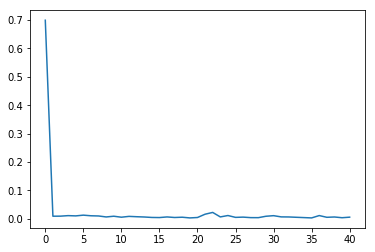

In [10]:
plt.plot(losses)

## Predict the test timeseries

In [12]:
with tf.Session() as sess:
    # Load model
    saver.restore(sess, "./model/time_series_model")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
    train_seed = list(train_ts_sc[-12:])
    
    # Predict
    for i in range(12):
        X_predict = np.array(train_seed[-12:]).reshape(1, 12, 1)
        y_predict = sess.run(
            y_pred,
            feed_dict={
                X_ph: X_predict})
        train_seed.append(y_predict[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./model/time_series_model


In [13]:
# Reverse MinMax Scaling
test_ts_pred = mms.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

In [14]:
compare = pd.DataFrame()
compare['Month'] = data['Month'][-12:]

compare['Milk Production'] = data['Milk Production'][-12:]
compare['Milk Production Predict'] = test_ts_pred

compare = compare.set_index('Month')
compare

,Milk Production,Milk Production Predict
Month,,
1975-01-01 01:00:00,834.0,816.897766
1975-02-01 01:00:00,782.0,790.655640
1975-03-01 01:00:00,892.0,880.737305
1975-04-01 01:00:00,903.0,863.438965
1975-05-01 01:00:00,966.0,936.985657
1975-06-01 01:00:00,937.0,917.065247
1975-07-01 01:00:00,896.0,891.736328
1975-08-01 01:00:00,858.0,862.335571
1975-09-01 01:00:00,817.0,814.139648


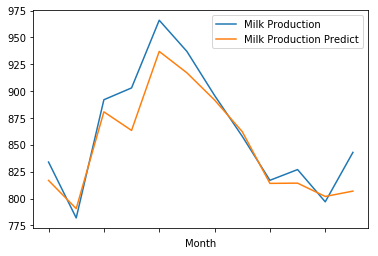

In [15]:
compare.plot()